![https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png](https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png)

# Initialization with traffic lights
INITIALIZE can be conditioned on traffic light state (as can DRIVE), if the states are passed to the API correctly. This notebook is a demonstration of the capabilities of both models to be conditioned on traffic light state.


In [1]:
# Some stuff to get us going:
!pip install invertedai
from IPython.display import clear_output
clear_output()

In [2]:
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import invertedai as iai
import time
clear_output()

In [3]:
#API key:
iai.add_apikey("")

## Setup

We begin by setting up the simulation

In [4]:
location = "iai:drake_street_and_pacific_blvd"
#location = "iai:marine_drive_viewpoint_3"

SIMULATION_LENGTH = 30
RENDERING_FOV = 130
FIGURE_SIZE = 10
AGENT_COUNT = 10
GIF_RATIO = 1.33
GIF_SIZE = 100*FIGURE_SIZE

## Preview map location

We can preview the map, and look at the traffic light locations to understand which of the lights control which road

(None, <matplotlib.image.AxesImage at 0x780bcfbfb310>)

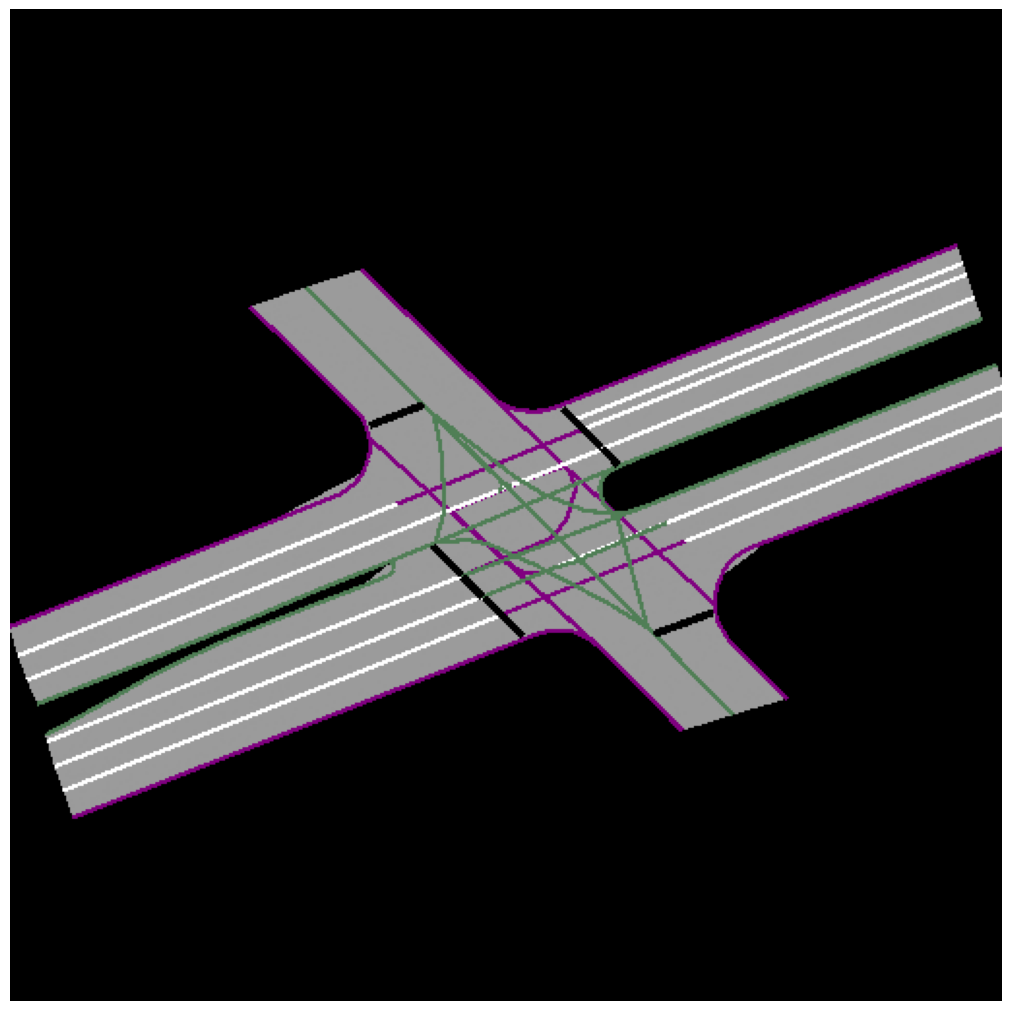

In [5]:
rendered_map = iai.location_info(location=location,rendering_fov=RENDERING_FOV).birdview_image.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off(), ax.imshow(rendered_map)

In [6]:
location_info = iai.location_info(location=location)
for actor in location_info.static_actors:
    print(actor)

actor_id=103760 agent_type='traffic-light' center=Point(x=0.883, y=-15.8905) orientation=0.7876 length=0.3421 width=3.7417 dependant=[103760]
actor_id=103761 agent_type='traffic-light' center=Point(x=-1.682, y=-13.3246) orientation=0.7876 length=0.3423 width=3.3199 dependant=[103761]
actor_id=103762 agent_type='traffic-light' center=Point(x=-4.3522, y=-10.7222) orientation=0.7876 length=0.3419 width=3.8255 dependant=[103762]
actor_id=103763 agent_type='traffic-light' center=Point(x=-7.697, y=-7.3018) orientation=0.7772 length=0.3421 width=5.5475 dependant=[103763]
actor_id=103764 agent_type='traffic-light' center=Point(x=23.2852, y=-15.506) orientation=1.9221 length=0.2903 width=8.218 dependant=[103764]
actor_id=103765 agent_type='traffic-light' center=Point(x=13.688, y=6.3305) orientation=-2.3732 length=0.3171 width=3.2149 dependant=[103765]
actor_id=103766 agent_type='traffic-light' center=Point(x=11.3971, y=8.6804) orientation=-2.3487 length=0.3177 width=3.3191 dependant=[103766]
ac

In [7]:
scene_plotter = iai.utils.ScenePlotter(rendered_map, RENDERING_FOV, (location_info.map_center.x, location_info.map_center.y), location_info.static_actors)

## Initializing on a controlled intersection

We are now in a position to initialize the simulation, with the above traffic light information, all we need to do is set the traffic lights appropriately. There are two main directions, and a left turn light in one direction. Our initial scenario will be a red light for the main road, and a green light for both side streets. The traffic light is passed as a dictionary.

In [ ]:
main_road_light_state = 'red'
left_turn_light = 'red'
side_road_light_state = 'green'
light_states = [
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    left_turn_light,
    side_road_light_state,
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    side_road_light_state
]
traffic_light = {actor.actor_id : light for actor, light in zip(location_info.static_actors, light_states)}

Now we run INITIALIZE and visualize the map containing agents:

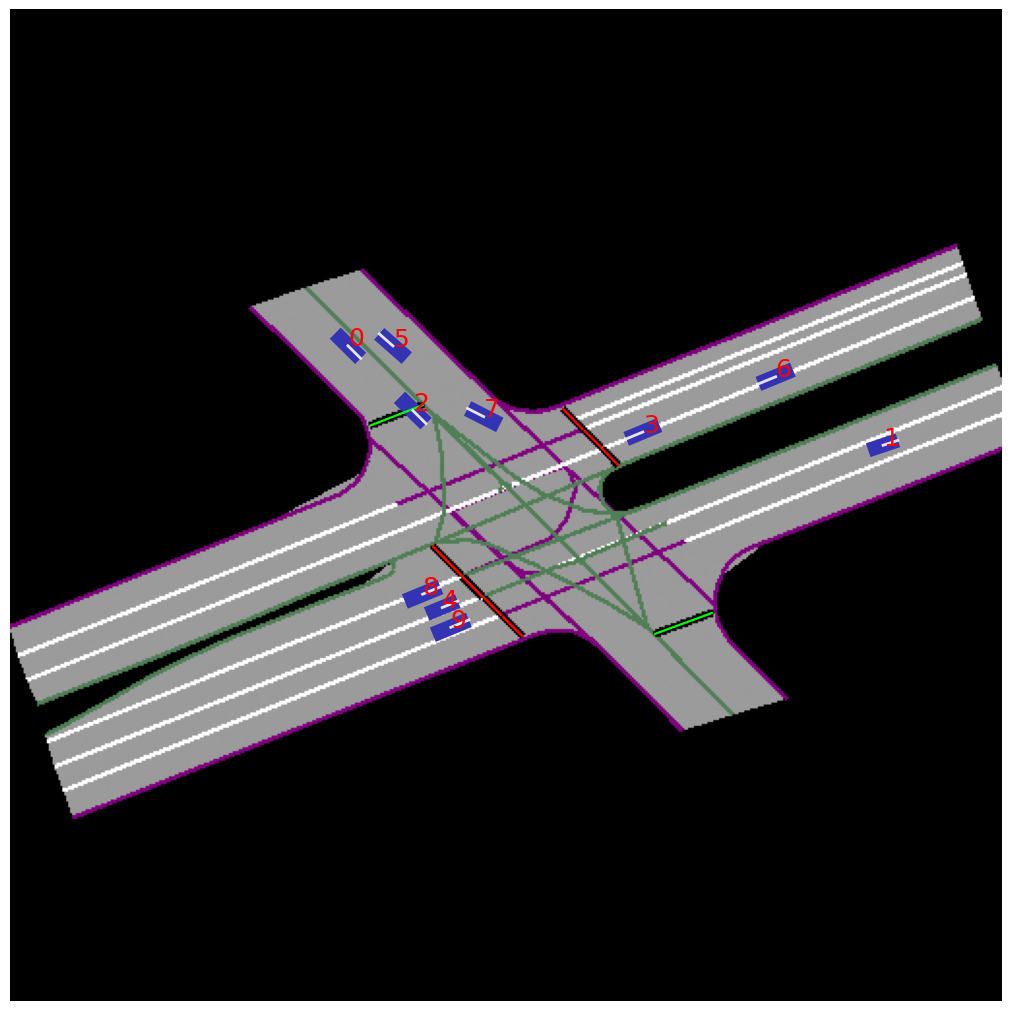

In [ ]:
response = iai.initialize(
    location,
    agent_attributes = None,
    states_history = None,
    traffic_light_state_history = [traffic_light],
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 0
)
agent_attributes = response.agent_attributes

fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    response.agent_states,
    response.agent_attributes,
    traffic_light_states = traffic_light,
    ax=ax,
    numbers=True,
    velocity_vec=False,
    direction_vec=True
)

And then we can run drive, conditioned on the traffic light state. In this current simulation, the traffic light does not change over the simulated time.

In [ ]:
agent_attributes = response.agent_attributes
scene_plotter.initialize_recording(response.agent_states, agent_attributes=agent_attributes, traffic_light_states=traffic_light)
updated_state = response
times = []
for t in range(SIMULATION_LENGTH):
    t0 = time.time()
    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        traffic_lights_states=traffic_light,
        get_birdview=False,
        location=location,
        get_infractions=False,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=traffic_light);
    print(f'Iteration {t}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.68 over 30 calls


And an assembled gif:

In [ ]:
%%capture
gif_name = 'iai-drive-side-road-green.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

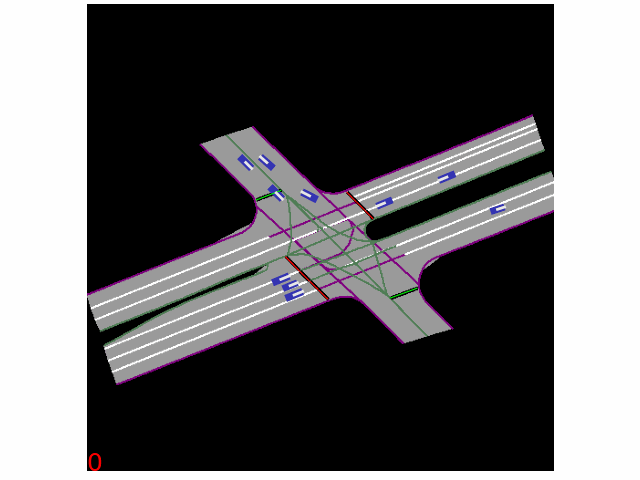

In [ ]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)

## Alternate traffic light
To demonstrate how the model reacts to different traffic light states, we now show what happens when we initialize with an alternate traffic light state: the main road now has the green light while the side roads are red.

In [8]:
main_road_light_state = 'green'
left_turn_light = 'green'
side_road_light_state = 'red'
light_states = [
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    left_turn_light,
    side_road_light_state,
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    side_road_light_state
]
traffic_light = {actor.actor_id : light for actor, light in zip(location_info.static_actors, light_states)}

We again run INITIALIZE

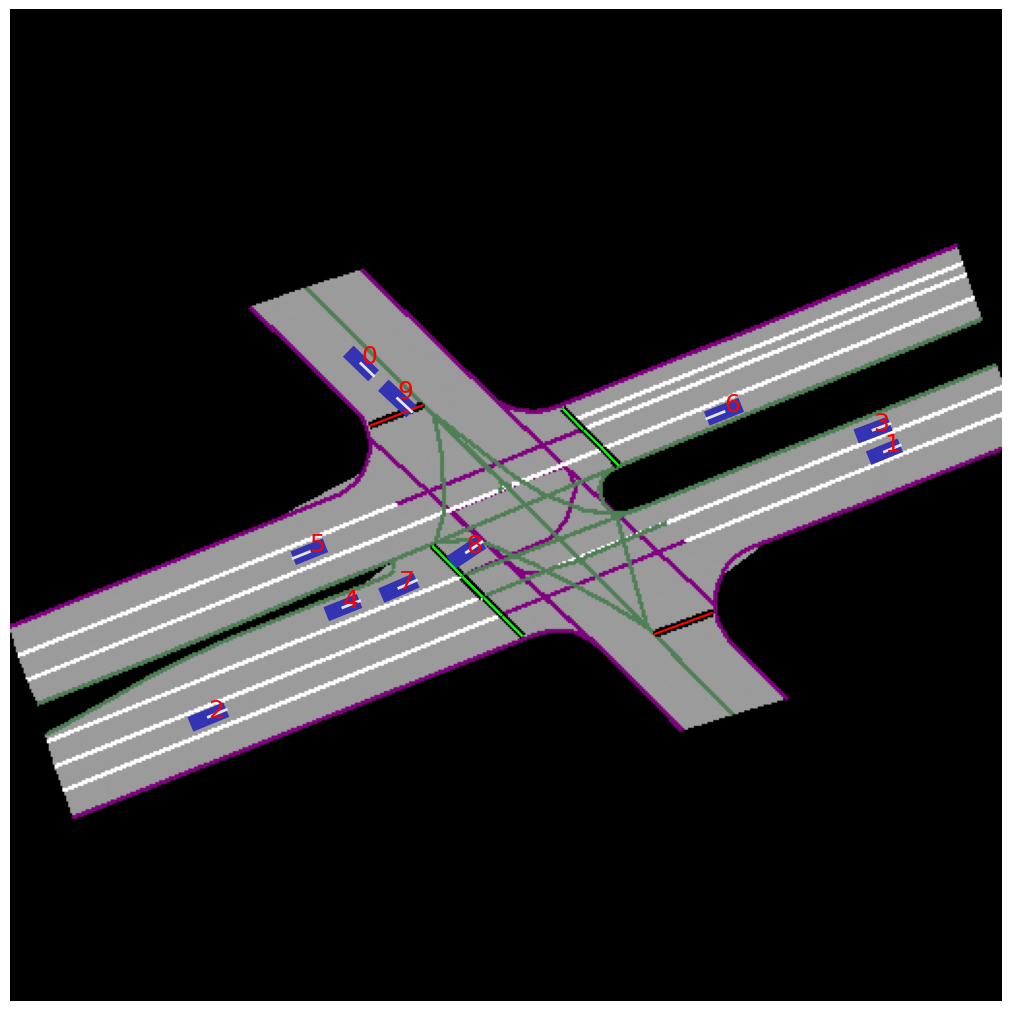

In [9]:
response = iai.initialize(
    location,
    agent_attributes = None,
    states_history = None,
    traffic_light_state_history = [traffic_light],
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 0
)
agent_attributes = response.agent_attributes

fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    response.agent_states,
    response.agent_attributes,
    traffic_light_states = traffic_light,
    ax=ax,
    numbers=True,
    velocity_vec=False,
    direction_vec=True
)

And simulate using DRIVE:

In [10]:
agent_attributes = response.agent_attributes
scene_plotter.initialize_recording(response.agent_states, agent_attributes=agent_attributes, traffic_light_states=traffic_light)
updated_state = response
times = []
for t in range(SIMULATION_LENGTH):
    t0 = time.time()
    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        traffic_lights_states=traffic_light,
        get_birdview=False,
        location=location,
        get_infractions=False,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=traffic_light);
    print(f'Iteration {t}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.43 over 30 calls


In [12]:
%%capture
gif_name = 'iai-drive-main-road-green.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

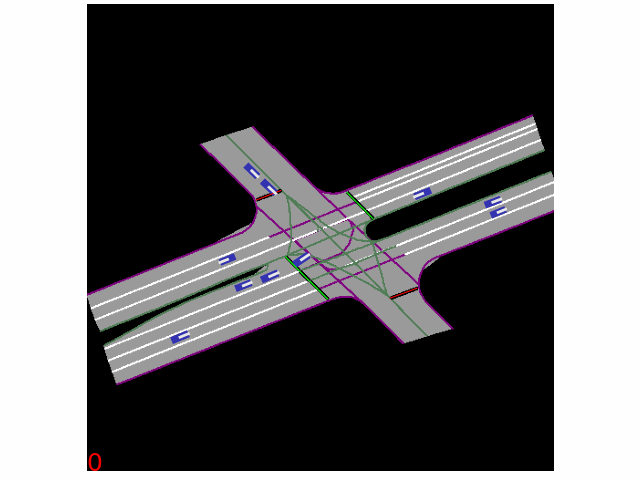

In [13]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)